# Cardiovascular desease detection

## Project by: PARAS VARSHNEY

### Importing Libraries

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.externals import joblib 
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")


from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

import scipy.stats as stats
from scipy.stats import norm ,rankdata

from scipy.special import boxcox1p
from scipy.stats import normaltest
import statsmodels
import statsmodels.api as sm
from scipy.optimize import curve_fit

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix


from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import classification_report,confusion_matrix

import xgboost as xgb
from catboost import CatBoostClassifier



In [22]:
data_url = "https://raw.githubusercontent.com/paras009/Cardiovascular-Disease-Detection/master/cardio_train.csv?token=AGEPDXH47ZCA3MSUDB6K7I26XQPH2"

In [60]:
# raw_df = pd.read_csv(data_url, sep=";")
raw_df = pd.read_csv("cardio_train.csv", sep=";")

In [61]:
raw_df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,988,22469,1,155,69.0,130,80,2,2,0,0,1,0
1,989,14648,1,163,71.0,110,70,1,1,0,0,1,1
2,990,21901,1,165,70.0,120,80,1,1,0,0,1,0
3,991,14549,2,165,85.0,120,80,1,1,1,1,1,0
4,992,23393,1,155,62.0,120,80,1,1,0,0,1,0


In [62]:
raw_df.columns

Index(['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio'],
      dtype='object')

In [63]:
raw_df.shape

(69301, 13)

In [64]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69301 entries, 0 to 69300
Data columns (total 13 columns):
id             69301 non-null int64
age            69301 non-null int64
gender         69301 non-null int64
height         69301 non-null int64
weight         69301 non-null float64
ap_hi          69301 non-null int64
ap_lo          69301 non-null int64
cholesterol    69301 non-null int64
gluc           69301 non-null int64
smoke          69301 non-null int64
alco           69301 non-null int64
active         69301 non-null int64
cardio         69301 non-null int64
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [65]:
raw_df.isnull().any()

id             False
age            False
gender         False
height         False
weight         False
ap_hi          False
ap_lo          False
cholesterol    False
gluc           False
smoke          False
alco           False
active         False
cardio         False
dtype: bool

In [66]:
# raw_df.to_csv(r'exported_cardiovascular.csv', index = False)

In [67]:
df_X = raw_df.drop(["id", "cardio", "ap_hi", "ap_lo"], axis=1)
df_y = raw_df.loc[:, "cardio"]

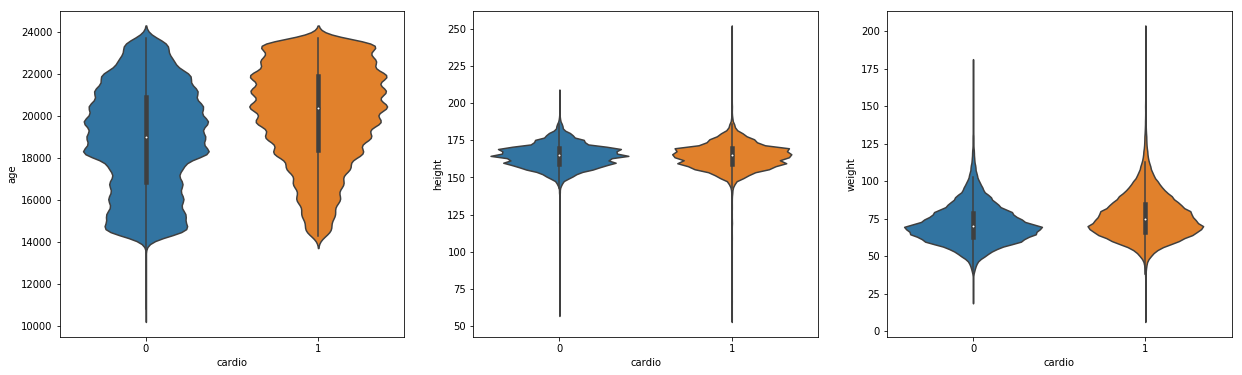

In [68]:
fig, axes = plt.subplots(1, 3, figsize=(21,6))
sns.violinplot(x="cardio", y="age", data=raw_df, ax=axes[0])
sns.violinplot(x="cardio", y="height", data=raw_df, ax=axes[1])
sns.violinplot(x="cardio", y="weight", data=raw_df, ax=axes[2])

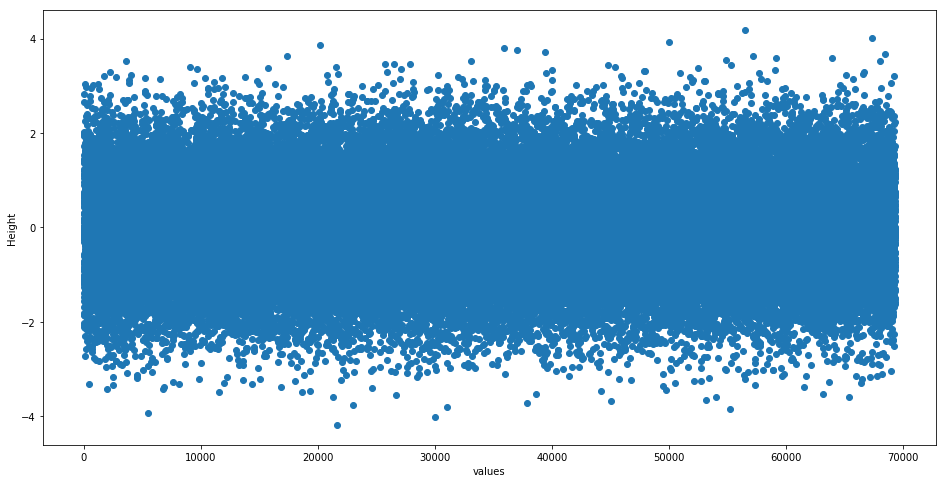

In [84]:
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(range(len(raw_df['weight'])), raw_df['age'])
ax.set_xlabel("values")
ax.set_ylabel("Height")
plt.show()

In [88]:
z = np.abs(stats.zscore(raw_df))
print(z)
threshold = 3
print(np.where(z > 3))

[[1.73243929 1.13180696 0.73302344 ... 0.23864069 0.49376463 0.99917784]
 [1.73240428 1.85318618 0.73302344 ... 0.23864069 0.49376463 1.00082284]
 [1.73236927 0.89303401 0.73302344 ... 0.23864069 0.49376463 0.99917784]
 ...
 [1.7338761  0.19889038 1.36421285 ... 4.19040018 2.02525646 1.00082284]
 [1.73394612 1.11011332 0.73302344 ... 0.23864069 2.02525646 1.00082284]
 [1.73398113 0.35041098 0.73302344 ... 0.23864069 0.49376463 0.99917784]]
(array([    3,     3,    13, ..., 69286, 69296, 69298], dtype=int64), array([ 9, 10,  8, ..., 10,  9, 10], dtype=int64))


In [ ]:
print(z[3][9])

In [94]:
Q1 = raw_df.quantile(0.25)
Q3 = raw_df.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

id             49405.000000
age                1.349002
gender             1.000000
height             1.433110
weight             1.289967
ap_hi             20.000000
ap_lo             10.000000
cholesterol        1.000000
gluc               0.000000
smoke              0.000000
alco               0.000000
active             0.000000
cardio             1.000000
dtype: float64


In [115]:
boston_df_o = raw_df[(z < 3).all(axis=1)]
boston_df_o.shape

(55388, 13)

In [116]:
raw_df_op = raw_df[~((raw_df < (Q1 - 1.5 * IQR)) |(raw_df > (Q3 + 1.5 * IQR))).any(axis=1)]
raw_df_op.shape

(37929, 13)

In [69]:
def rank_based_normalization(x):  
    newX = norm.ppf(rankdata(x)/(len(x) + 1))
    return newX

In [70]:
def feature_engg(feature):
    fig, axes = plt.subplots(1,2, figsize=(21,6))
    sns.distplot(feature, ax=axes[0])
    sm.qqplot(feature, stats.norm, fit=True, line='45', ax=axes[1]);
    k2_1, p1 = normaltest(feature)
    print("Normal test P1: ",p1)

    fig, axes = plt.subplots(1,2, figsize=(21,6))
    sns.distplot(rank_based_normalization(feature), ax=axes[0])
    axes[0].set_xlabel('Normalized')
    sm.qqplot(rank_based_normalization(feature), stats.norm, fit=True, line='45', ax=axes[1]);
    k2_2, p2 = normaltest(rank_based_normalization(feature))
    print("Normal test P2: ",p2)
    return rank_based_normalization(feature)

Normal test P1:  0.0
Normal test P2:  0.9723297298997556


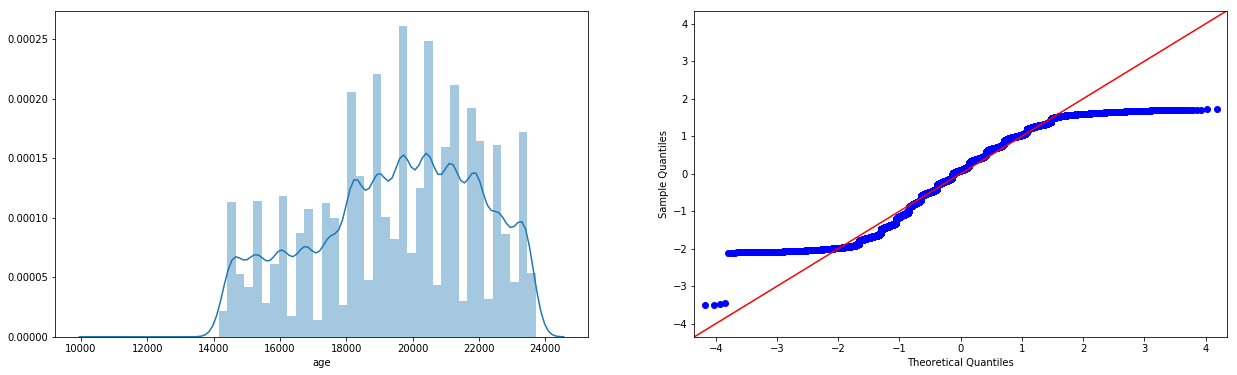

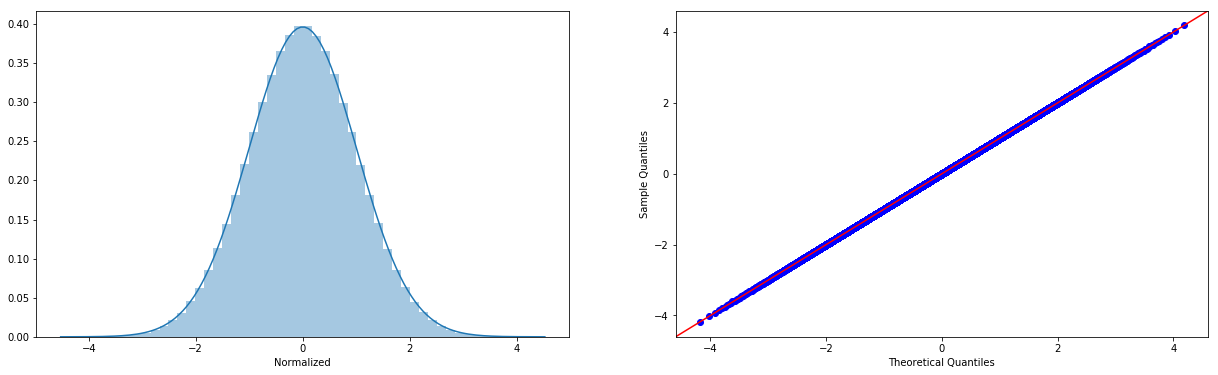

In [71]:
feature = raw_df['age']
raw_df['age'] = feature_engg(feature)

Normal test P1:  0.0
Normal test P2:  0.9914757251083357


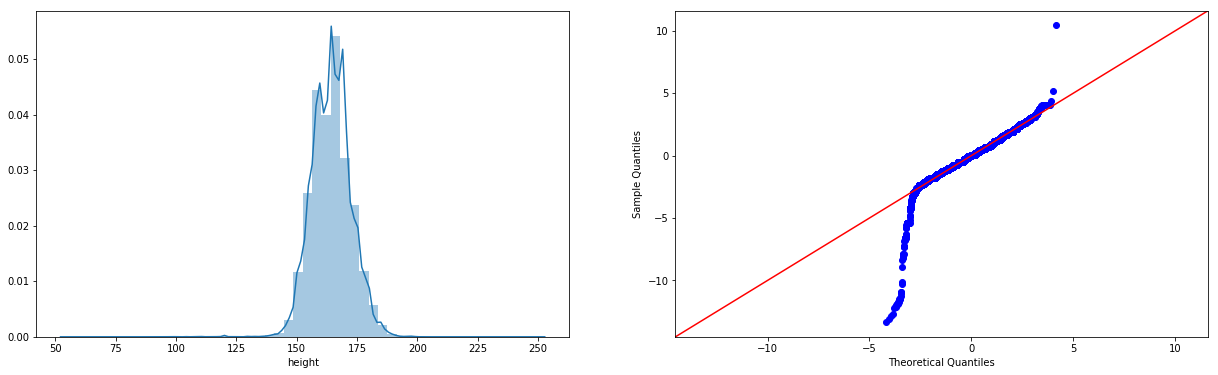

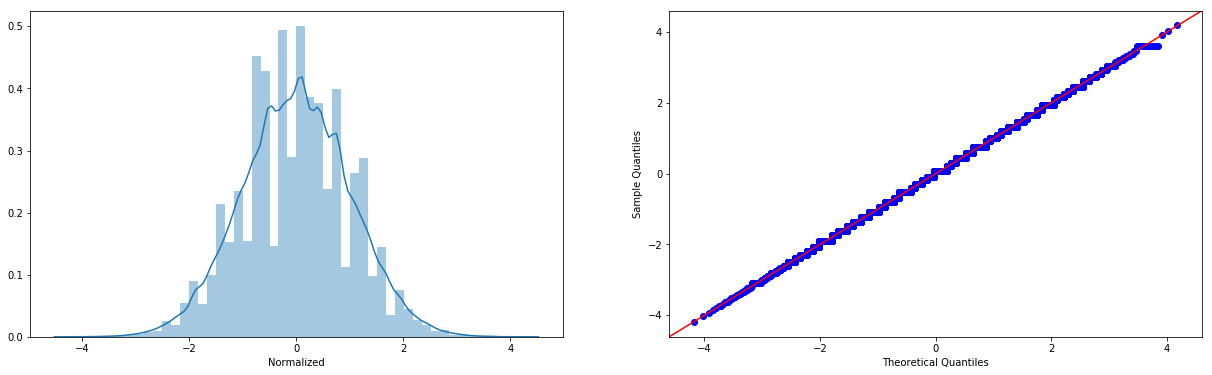

In [72]:
feature = raw_df['height']
raw_df['height'] = feature_engg(feature)

Normal test P1:  0.0
Normal test P2:  0.9710165444396909


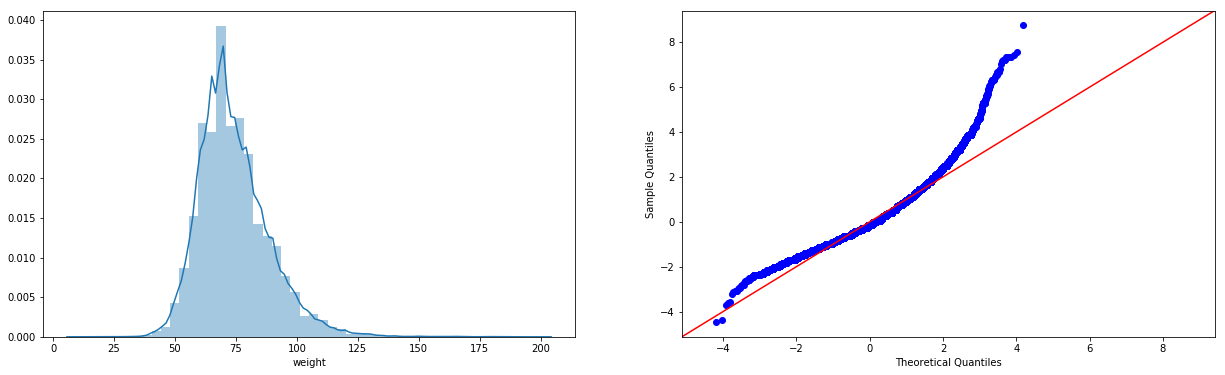

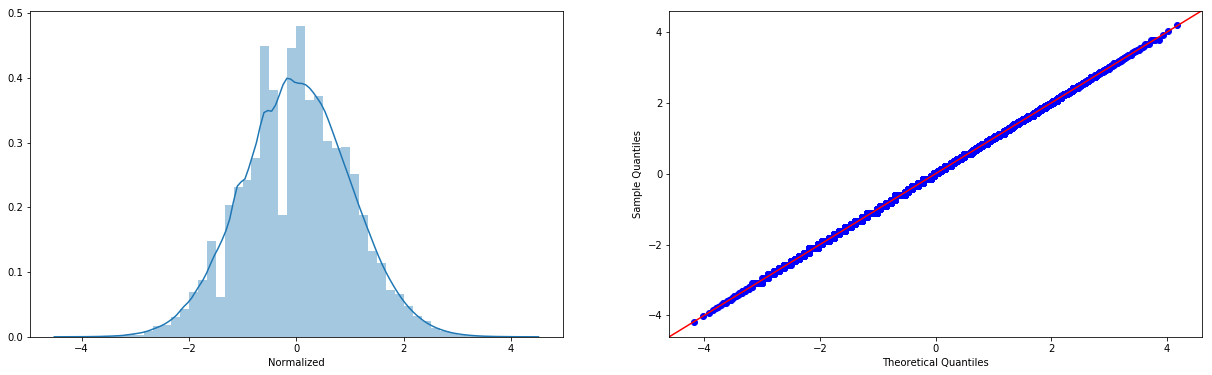

In [73]:
feature = raw_df['weight']
raw_df['weight'] = feature_engg(feature)

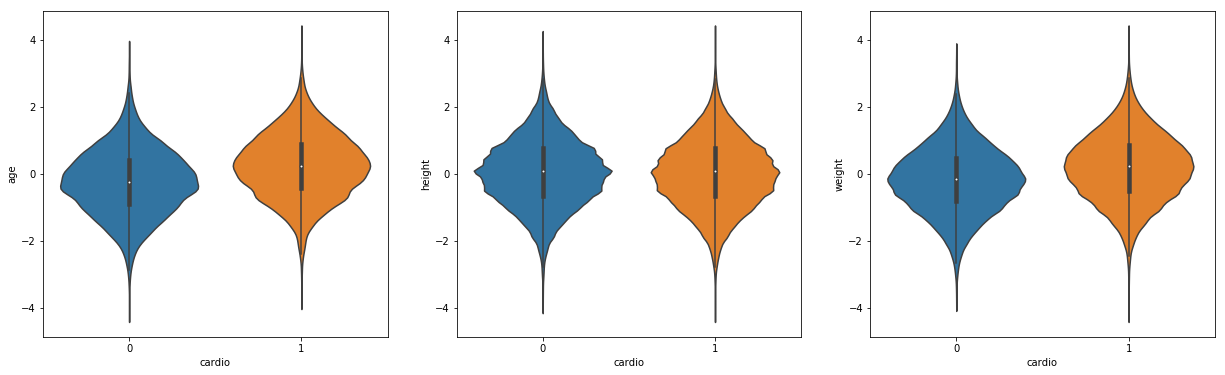

In [75]:
fig, axes = plt.subplots(1, 3, figsize=(21,6))
sns.violinplot(x="cardio", y="age", data=raw_df, ax=axes[0])
sns.violinplot(x="cardio", y="height", data=raw_df, ax=axes[1])
sns.violinplot(x="cardio", y="weight", data=raw_df, ax=axes[2])

In [74]:
# feature = raw_df["ap_hi"]

# fig, axes = plt.subplots(1,3, figsize=(21,6))
# sns.distplot(feature, ax=axes[0])
# sns.distplot(np.log1p(feature), ax=axes[1])
# axes[1].set_xlabel('log(1+feature)')
# sm.qqplot(np.log1p(feature), stats.norm, fit=True, line='45', ax=axes[2]);

### Feature Engineering

##### converting log normal to normal

<hr>
<hr>

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.4, random_state=44)

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print(X_train, X_test)

In [ ]:
classifier = Sequential()
classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu', input_dim = df_X.shape[1]))
classifier.add(Dropout(0.2))
classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu'))
classifier.add(Dropout(0.2))
classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu'))
classifier.add(Dropout(0.2))
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
classifier.fit(df_X, df_y, batch_size = 20, epochs = 10)

In [ ]:
y_pred = classifier.predict(X_test)
print("\nPredicted values: "+str(y_pred)+"\n")

for i in range(len(y_pred)):
    if y_pred[i] >= 0.5:
        y_pred[i] = 1
    else:
        y_pred[i] = 0


print(y_test, y_pred)
# Making the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
accuracy = (cm[0,0]+cm[1, 1])/(cm[0,0]+cm[1, 1]+cm[1,0]+cm[0, 1])
print("\nTest Accuracy: "+str(accuracy)+"\n")

In [ ]:
models = []
models.append(("LR",LogisticRegression()))
models.append(("NB",GaussianNB()))
models.append(("RF",RandomForestClassifier()))
# models.append(("SVC",SVC()))
models.append(("Dtree",DecisionTreeClassifier()))
models.append(("XGB",xgb.XGBClassifier()))
models.append(("KNN",KNeighborsClassifier()))
models.append(("XGBCat",CatBoostClassifier(iterations=10, learning_rate=1, depth=5)))

for name,model in models:
    kfold = KFold(n_splits=2, random_state=22)
    cv_result = cross_val_score(model,X_train,y_train, cv = kfold, scoring = "accuracy")
    print(name, cv_result)

In [ ]:
xgb_model = xgb.XGBClassifier().fit(X_train, y_train)
print("Training: "+str(xgb_model.score(X_train, y_train)))
print("Testing: "+str(xgb_model.score(X_test, y_test)))